user stories classification with machine learning methods (SVM,Native Bayes,KNN)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\38673\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\38673\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\38673\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


              precision    recall  f1-score   support

           0       0.63      0.92      0.75        36
           1       0.59      0.82      0.68       212
           2       0.55      0.49      0.52        35
           3       0.67      0.22      0.33        18
           4       0.87      0.65      0.74        51
           5       0.93      0.50      0.65        28
           6       0.88      0.54      0.67        80
           7       0.60      0.51      0.55       169

    accuracy                           0.64       629
   macro avg       0.71      0.58      0.61       629
weighted avg       0.67      0.64      0.63       629

              precision    recall  f1-score   support

           0       0.72      0.94      0.82        36
           1       0.59      0.78      0.67       212
           2       0.73      0.54      0.62        35
           3       0.73      0.44      0.55        18
           4       0.93      0.75      0.83        51
           5       0.89 

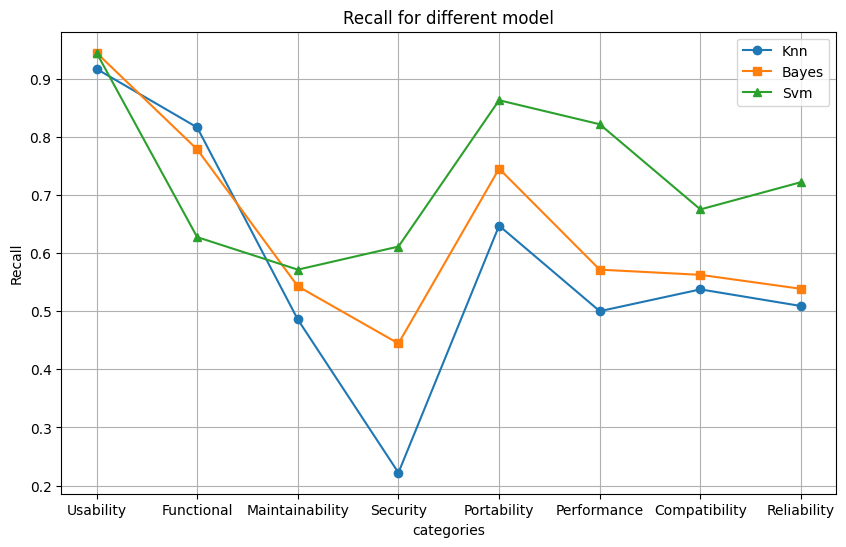

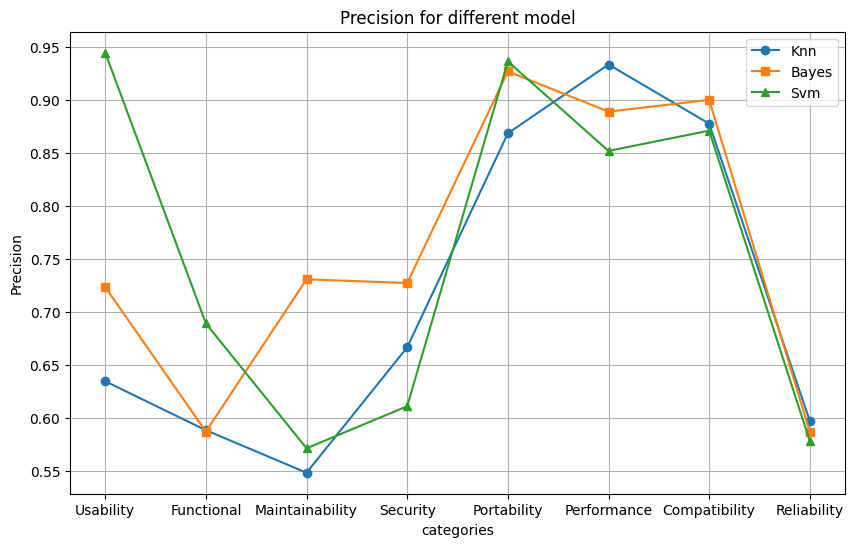

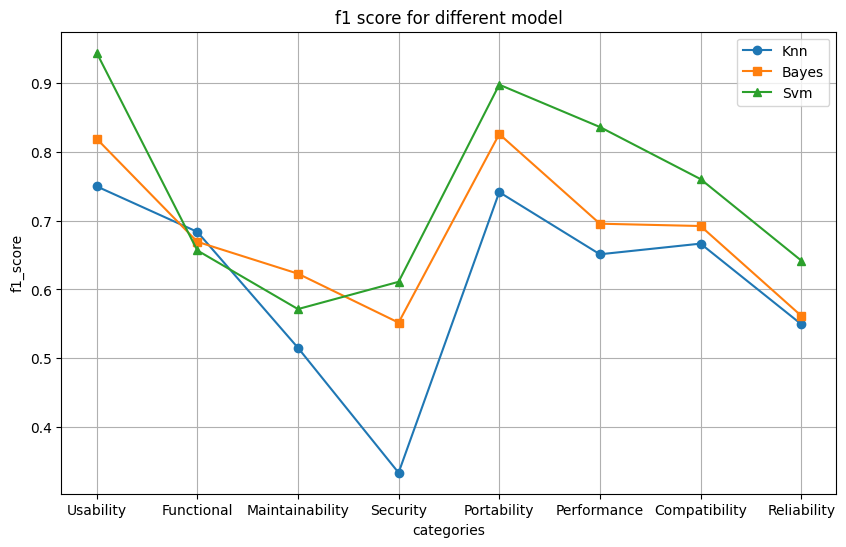

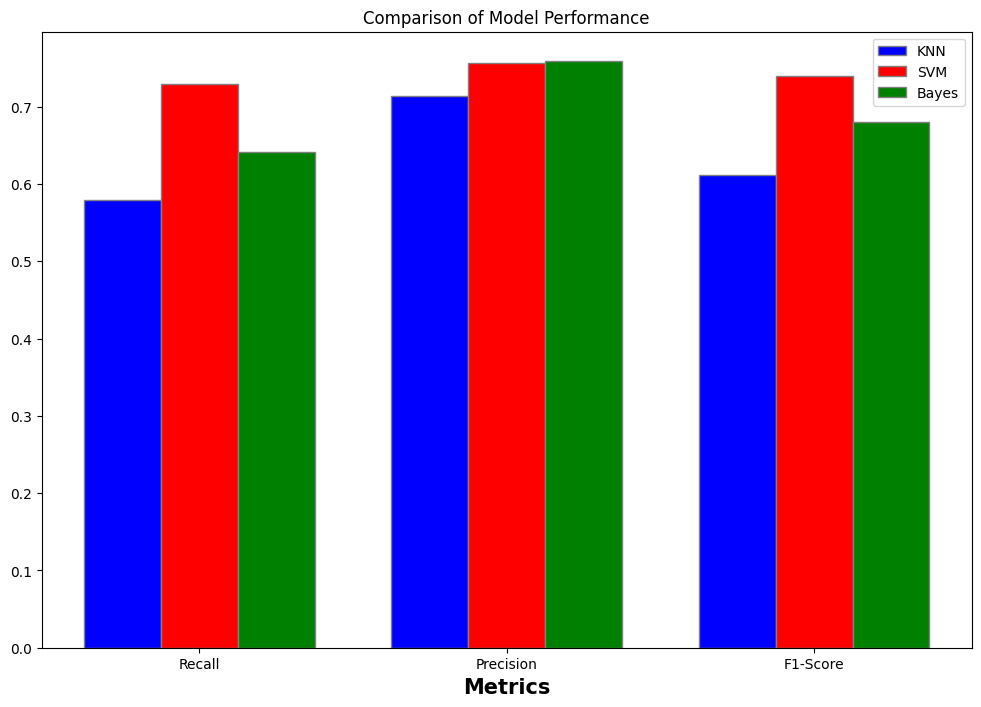

In [14]:
import pandas as pd
import re
import string
from collections import Counter
from nltk import download, word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
download('punkt')
download('wordnet')
download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))




#data-load
df = pd.read_csv('dataset/user_stories_data.csv')
text_data = df['texts'].tolist()
label_data = df['labels'].tolist()
labels = {'Usability':0,
          'Functional':1,
          'Maintainability':2,
          'Security':3,
          'Portability':4,
          'Performance':5,
          'Compatibility':6,
          'Reliability':7
          }

label_counts = Counter(label_data) #data distribution 
#print(label_counts)





#preprocessing
def load_stopwords(stopwords_file):
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f.readlines()]
    return stopwords
lemmatizer = WordNetLemmatizer()
def preprocess_texts(texts):
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def remove_urls(sentence):
        return re.sub(r'https?://\S+|www\.\S+', '', sentence)
    def remove_stopwords(sentence):
        # tokens = word_tokenize(sentence)
        # filtered_sentence = []
        # for token in tokens:
        #     if token not in stopwords:
        #         filtered_sentence.append(token)
        # return ' '.join(filtered_sentence)
        tokens = word_tokenize(sentence)
        filtered_sentence = [w for w in tokens if not w in stop_words]
        return ' '.join(filtered_sentence)

    def remove_punctuation(sentence):
        translator = str.maketrans('', '', string.punctuation)
        lower_case_sentence = sentence.lower().translate(translator)
        words = lower_case_sentence.split()
        return ' '.join(words)

    def lemmatize_text(text):
        tokens = word_tokenize(text)
        tagged_tokens = pos_tag(tokens)
        lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in tagged_tokens]
        return ' '.join(lemmatized_tokens)
    #remove URL
    # stopwords = load_stopwords('stopwords.txt')
    texts = [remove_urls(text) for text in texts]
    # remove stopwords and punctuation
    texts = [remove_punctuation(text) for text in texts]
    # texts = [remove_stopwords(text) for text in texts]
    # lematization
    texts = [lemmatize_text(text) for text in texts]

    return texts


#feature extraction
def extractByTfIdf(texts):
    vectorizer = TfidfVectorizer(max_df=0.9, ngram_range=(1, 2))
    X = vectorizer.fit_transform(texts)
    return X





#main
preprocessed_texts = preprocess_texts(text_data)
labels_encoder = LabelEncoder()
X = extractByTfIdf(preprocessed_texts)
encoded_labels = labels_encoder.fit_transform(label_data)
X_train, X_test, y_train, y_test = train_test_split(X,encoded_labels, test_size=0.2, random_state=42)


# train 
def train(model, X_train, y_train):
    if model == "Bayes":
        #train 
        model = ComplementNB(alpha=1.0, fit_prior=False, norm=True)
    elif model == "Knn":
        model = KNeighborsClassifier(n_neighbors=10)
    elif model == "Svm":
        model = SVC(kernel='linear',class_weight='balanced')
    model.fit(X_train, y_train) 
    return model 


# Knn 
knn = train("Knn", X_train, y_train)
y_pred_knn = knn.predict(X_test)
report_knn = classification_report(y_test,y_pred_knn,output_dict=True)
print(classification_report(y_test, y_pred_knn))



# Naive Bayes
NB = train("Bayes", X_train, y_train)
y_pred_bayes = NB.predict(X_test)
report_bayes = classification_report(y_test,y_pred_bayes,output_dict=True)
print(classification_report(y_test,y_pred_bayes))


# SVM
SVM = train("Svm", X_train, y_train)
y_pred_svm = SVM.predict(X_test)
report_svm = classification_report(y_test,y_pred_svm,output_dict=True)
print(classification_report(y_test,y_pred_svm))

#evaluation and plots
def get_item(String,report,list):
    for i in range(8):
        list.append(report[str(i)][String])
    return list
    
recall_knn = []
recall_svm = []
recall_bayes = []

recall_knn = get_item('recall',report_knn,recall_knn)
recall_svm = get_item('recall',report_svm,recall_svm)
recall_bayes = get_item('recall',report_bayes,recall_bayes)
recalls = [recall_knn, recall_svm, recall_bayes]
categories = list(labels.keys())
plt.figure(figsize=(10,6))
plt.plot(categories,recall_knn,marker='o',label='Knn')
plt.plot(categories,recall_bayes,marker='s',label='Bayes')
plt.plot(categories,recall_svm,marker='^',label='Svm')
plt.xlabel('categories')
plt.ylabel('Recall')
plt.title('Recall for different model')
plt.legend()
plt.grid(True)
plt.savefig('recall_comparison.png')
plt.show()

precision_knn = []
precision_svm = []
precision_bayes = []

precision_knn = get_item('precision',report_knn,precision_knn)
precision_svm = get_item('precision',report_svm,precision_svm)
precision_bayes = get_item('precision',report_bayes,precision_bayes)
precisions = [precision_knn,precision_bayes,precision_svm]
categories = list(labels.keys())
plt.figure(figsize=(10,6))
plt.plot(categories,precision_knn,marker='o',label='Knn')
plt.plot(categories,precision_bayes,marker='s',label='Bayes')
plt.plot(categories,precision_svm,marker='^',label='Svm')
plt.xlabel('categories')
plt.ylabel('Precision')
plt.title('Precision for different model')
plt.legend()
plt.grid(True)
plt.savefig('precision_comparsion.png')
plt.show()
f1score_knn = []
f1score_svm = []
f1score_bayes = []

f1_score_knn = get_item('f1-score',report_knn,f1score_knn)
f1_score_svm = get_item('f1-score',report_svm,f1score_svm)
f1score_bayes = get_item('f1-score',report_bayes,f1score_bayes)
f1scores = [f1score_knn,f1score_svm,f1score_bayes]
categories = list(labels.keys())
plt.figure(figsize=(10,6))
plt.plot(categories,f1score_knn,marker='o',label='Knn')
plt.plot(categories,f1score_bayes,marker='s',label='Bayes')
plt.plot(categories,f1score_svm,marker='^',label='Svm')
plt.xlabel('categories')
plt.ylabel('f1_score')
plt.title('f1 score for different model')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_comparison.png')
plt.show()


average_recall_knn = np.mean(recall_knn)
average_recall_svm = np.mean(recall_svm)
average_recall_bayes = np.mean(recall_bayes)

average_precision_knn = np.mean(precision_knn)
average_precision_svm = np.mean(precision_svm)
average_precision_bayes = np.mean(precision_bayes)

average_f1score_knn = np.mean(f1score_knn)
average_f1score_svm = np.mean(f1score_svm)
average_f1score_bayes = np.mean(f1score_bayes)

barWidth = 0.25
r1 = np.arange(3)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(12, 8))
plt.bar(r1, [average_recall_knn, average_precision_knn, average_f1score_knn], color='b', width=barWidth, edgecolor='grey', label='KNN')
plt.bar(r2, [average_recall_svm, average_precision_svm, average_f1score_svm], color='r', width=barWidth, edgecolor='grey', label='SVM')
plt.bar(r3, [average_recall_bayes, average_precision_bayes, average_f1score_bayes], color='g', width=barWidth, edgecolor='grey', label='Bayes')

plt.xlabel('Metrics', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(3)], ['Recall', 'Precision', 'F1-Score'])

plt.legend()

plt.title('Comparison of Model Performance')
plt.savefig('model_performance_comparison.png')
plt.show()
